<a href="https://colab.research.google.com/github/VasileiosKarapoulios/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import numpy as np
import math
import random
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
yes = os.listdir("/content/drive/My Drive/brain_tumor_dataset/yes")
no = os.listdir("/content/drive/My Drive/brain_tumor_dataset/no") 

(340, 291, 3)
(630, 630, 3)
(348, 297, 3)
(355, 320, 3)
(256, 197, 3)


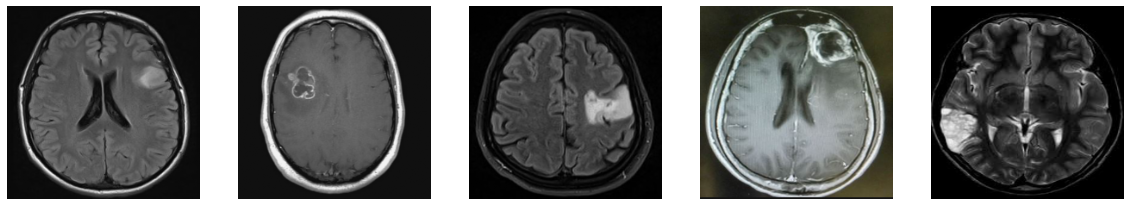

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0, 5):
    rand = np.random.randint(len(yes))
    img  = imread("/content/drive/My Drive/brain_tumor_dataset/yes/" + yes[rand])
    print(img.shape)
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

In [6]:
TRAIN_DATA_PATH = "/content/drive/My Drive/brain_tumor_dataset_train_test_valid/train"
TEST_DATA_PATH = "/content/drive/My Drive/brain_tumor_dataset_train_test_valid/test"
VALID_DATA_PATH = "/content/drive/My Drive/brain_tumor_dataset_train_test_valid/validation"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

In [7]:
class CNN(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=(3,3))    #padding="same" x = F.pad(x, (0, 0, 1, 2))
    self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3))
    self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3))
    #self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3))
    self.conv4 = nn.Conv2d(128, 32, kernel_size=(3,3))
    self.pool = nn.MaxPool2d(2, 2) 
    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(9216,2048)
    self.fc2 = nn.Linear(2048,1024)
    self.fc3 = nn.Linear(1024,512)
    self.fc4 = nn.Linear(512,128)
    self.fc5 = nn.Linear(128,32)
    self.fc6 = nn.Linear(2048,1)
    #self.fc7 = nn.Linear(16,8)
    #self.fc8 = nn.Linear(8,num_classes)
    self.avgpool = nn.AvgPool2d(kernel_size=(3,3))
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv4(x)
    x = F.relu(x)
    #x = self.pool(x)
    #x = x.reshape(x.shape[0], -1)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.dropout(x)
    '''x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.dropout(x)'''
    x = self.fc6(x)
    #x = F.relu(x)
    #x = self.dropout(x)
    #x = self.fc7(x)
    #x = F.relu(x)
    #x = self.dropout(x)
    #x = self.fc8(x)
    x = self.sigmoid(x)

    return x

# Hyperparameters
num_epochs = 50
learning_rate = 0.0003
batch_size = 16
in_channels = 3
num_classes = 2

model = CNN(in_channels, num_classes).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = DataLoader(test_data, batch_size=40, shuffle=True, num_workers=4) 
valid_data = ImageFolder(root=VALID_DATA_PATH, transform=TRANSFORM_IMG)
valid_data_loader  = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=4) 

In [9]:
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Number of test samples: ", len(valid_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure

Number of train samples:  193
Number of test samples:  40
Number of test samples:  20
Detected Classes are:  {'no': 0, 'yes': 1}


In [10]:
temp = 99999
model.train()
for epoch in range(num_epochs):  
  train_loss = 0.0
  valid_loss = 0.0 
  for step, (x, y) in enumerate(train_data_loader):    #Forward-Backward
      img = x.to(device)
      labels = y.to(device)
      labels = labels.unsqueeze(1).float()
      output = model(img)      
      loss = criterion(output, labels) 
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()
      train_loss += loss.item() * img.size(0)

  model.eval()
  num_correct = 0
  num_samples = 0
  with torch.no_grad():
    for step, (x, y) in enumerate(valid_data_loader):   # Validation
      img = x.to(device)
      labels = y.to(device) 
      labels = labels.unsqueeze(1).float()
      scores = model(img)
      predictions = scores
      predictions = np.round(predictions.cpu())
      predictions = predictions.to(device)
      loss = criterion(scores, labels)
      valid_loss += loss.item() * img.size(0)

      num_correct += (predictions==labels).sum()
      num_samples += predictions.size(0)

    acc = float(num_correct)/float(num_samples)*100
    print("Accuracy:", acc)

  train_loss = train_loss/len(train_data_loader.sampler)
  valid_loss = valid_loss/len(valid_data_loader.sampler)
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  if valid_loss < temp: 
      temp = valid_loss
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
      }
      print("Saving model...")
      torch.save(checkpoint, "my_checkpoint.pth.tar")

  model.train()

Accuracy: 50.0
Epoch: 0 	Training Loss: 0.674188 	Validation Loss: 0.716202
Saving model...
Accuracy: 50.0
Epoch: 1 	Training Loss: 0.643600 	Validation Loss: 0.715132
Saving model...
Accuracy: 50.0
Epoch: 2 	Training Loss: 0.654399 	Validation Loss: 0.678999
Saving model...
Accuracy: 50.0
Epoch: 3 	Training Loss: 0.595706 	Validation Loss: 0.746704
Accuracy: 65.0
Epoch: 4 	Training Loss: 0.591472 	Validation Loss: 0.660501
Saving model...
Accuracy: 65.0
Epoch: 5 	Training Loss: 0.540881 	Validation Loss: 0.683025
Accuracy: 65.0
Epoch: 6 	Training Loss: 0.525861 	Validation Loss: 0.669788
Accuracy: 70.0
Epoch: 7 	Training Loss: 0.525785 	Validation Loss: 0.581751
Saving model...
Accuracy: 70.0
Epoch: 8 	Training Loss: 0.508618 	Validation Loss: 0.629986
Accuracy: 70.0
Epoch: 9 	Training Loss: 0.490290 	Validation Loss: 0.673537
Accuracy: 70.0
Epoch: 10 	Training Loss: 0.449083 	Validation Loss: 0.681888
Accuracy: 70.0
Epoch: 11 	Training Loss: 0.450689 	Validation Loss: 0.653467
Accura

In [11]:
saved_model = torch.load("/content/my_checkpoint.pth.tar")
model.load_state_dict(saved_model["state_dict"])
optimizer.load_state_dict(saved_model["optimizer"])

Accuracy: 77.5


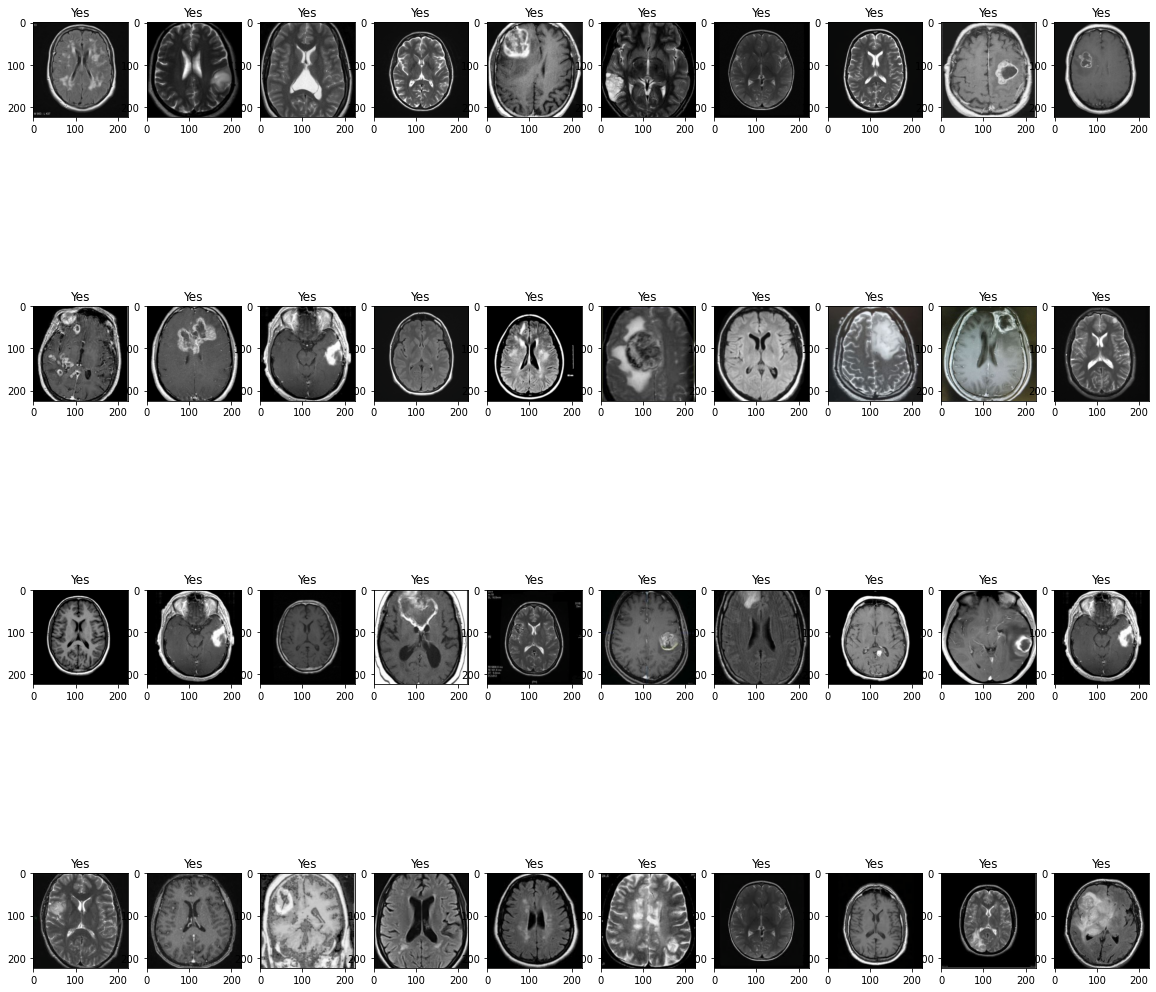

In [12]:
fig, ax = plt.subplots(nrows = 4, ncols = 10, figsize = (20,20))
model.eval()
num_correct= 0
num_samples = 0

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

with torch.no_grad():
  for step, (x, y) in enumerate(test_data_loader):
    x = x.to(device)
    y = y.to(device)
    y = y.unsqueeze(1).float()
    scores = model(x)
    predictions = scores
    predictions = np.round(predictions.cpu())
    predictions = predictions.to(device)
    num_correct += (predictions==y).sum()
    num_samples += predictions.size(0)
    
    count = 0
    count1 = 0
    count2 = 0
    for i in x:
      scores = model(i.unsqueeze(1).permute(1,0,2,3))
      predictions = scores
      ax[count,count1].imshow(inv_normalize(i.cpu()).permute(1,2,0))
      if predictions[0] == 0:
        ax[count,count1].set_title("No")
      else: 
        ax[count,count1].set_title("Yes")
      count=count+1
      count2 = count2 + 1
      if count == 4 or count == 9 or count == 14 or count == 19 or count == 24 or count == 29 or count ==34:
        count = 0
        count1 = count1 + 1

  acc = float(num_correct)/float(num_samples)*100
  print("Accuracy:", acc)

In [13]:
#!pip install torch-summary

In [14]:
#from torchsummary import summary
#summary(model, (3, 128, 128))

In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=4) 

In [16]:
img, target = next(iter(test_data_loader)) 
print(img.shape)
print(target)

torch.Size([1, 3, 224, 224])
tensor([0])


In [17]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): 
      self.hook = m.register_forward_hook(self.hook_fn)  # attach the hook to the specified layer
    def hook_fn(self, module, input, output): 
      self.features = ((output.cpu()).data).numpy() # copy the activation features as an instance variable
    def remove(self): 
      self.hook.remove()

In [18]:
final_layer = model._modules.get('conv4') # Last convolutional layer
activated_features = SaveFeatures(final_layer) # attach the call back hook to the last convolutional layer of the model

In [19]:
model = model.cpu()
img = img.cpu()
target = target.cpu()
target = target.unsqueeze(1).float()
scores = model(img)

In [20]:
y_pred = scores
print("Prediction: ", y_pred)
y_pred = y_pred.detach().numpy()
pred_probabilities = np.round(y_pred[0][0])
print("Predicted Class: ", np.int(pred_probabilities))

Prediction:  tensor([[0.0004]], grad_fn=<SigmoidBackward>)
Predicted Class:  0


In [24]:
def getCAM(feature_conv, weight_fc, class_idx):
    print("Feature_conv shape: ", feature_conv.shape)
    _, nc, h, w = feature_conv.shape
    temp = feature_conv[0,:,:, ].reshape((nc, h*w))
    cam = weight_fc.dot(temp)
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [25]:
weight_params = list(model._modules.get('fc6').parameters()) # This gives a list of weights for the fully connected layers 
print(len(weight_params))
weight = np.squeeze(weight_params[0].cpu().data.numpy())
print("Weight shape:", weight.shape)

2
Weight shape: (2048,)


In [26]:
cam_img = getCAM(activated_features.features, weight, pred_probabilities)
print(cam_img[0].shape)

Feature_conv shape:  (1, 32, 24, 24)


ValueError: ignored

In [ ]:
imshow(cam_img[0], alpha=0.5, cmap='jet')